In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from glob import glob
from zimp.pos.tokenization.builder import SentenceTokenizerStrategy, build_sentence_tokenizer
from zimp.pos.sentence_count_analyzer import SentenceCountAnalyzer
from sklearn.metrics import mean_absolute_error

plt.style.use('seaborn-whitegrid')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Martin\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Martin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package perluniprops to
[nltk_data]     C:\Users\Martin\AppData\Roaming\nltk_data...
[nltk_data]   Package perluniprops is already up-to-date!


In [2]:
def is_punctuation(pos_tag):
    return pos_tag in ['!', '.', ',', '?', ':', ';', '-', '-LRB-', '-RRB-']

def is_eos(pos_tag):
    return pos_tag == '.'

def extract_text(treebank_str):
    text, sentence_count = '', 0
    for line in treebank_str:
        if line == '\n':
            text += ' '
        else:
            line_parts = line.split('\t')
            token = line_parts[0]
            text = text + ' ' if text and not is_punctuation(line_parts[1]) else text
            text += token
            sentence_count += 1 if is_eos(line_parts[1]) else 0
    return text,sentence_count

In [3]:
texts = []
sentence_counts = []
for file in glob('dependency_treebank/*.dp'):
    with open(file, 'r') as f:
        txt, sc = extract_text(f.readlines())
        texts.append(txt)
        sentence_counts.append(sc)

In [4]:
stats = []
for strategy in SentenceTokenizerStrategy:
    print(f'{strategy.name}...')
    tokenizer = build_sentence_tokenizer(strategy, 'english', texts)
    predicted_sentence_cnt = []
    for txt in texts:
        predicted_sentence_cnt.append(len(tokenizer.tokenize_text(txt)))
    stats.append(pd.Series(predicted_sentence_cnt, name=strategy.name))

stats.append(pd.Series(sentence_counts, name='GROUND_TRUTH'))

SIMPLE...
PUNKT...
CORPUS_PUNKT...
EUROPARL...
SPACY...


In [5]:
df = pd.DataFrame(stats).T
df

,SIMPLE,PUNKT,CORPUS_PUNKT,EUROPARL,SPACY,GROUND_TRUTH
0,6,2,2,2,2,2
1,1,1,1,1,1,1
2,45,30,32,26,30,30
3,31,17,17,17,16,17
4,14,3,3,3,3,3
...,...,...,...,...,...,...
194,2,1,1,1,1,1
195,3,2,1,1,1,1
196,3,1,1,1,1,1
197,18,12,11,11,11,11


In [6]:
def plot_mae(label_lst, dataset_name):
    scores = np.zeros((len(label_lst), len(label_lst)))
    for j, k in list(itertools.combinations(range(len(label_lst)), 2)):
        scores[j,k] = mean_absolute_error(label_lst[j], label_lst[k])
        scores[k,j] = scores[j,k]
    
    plt.figure(figsize=(10,8))
    sns.heatmap(
        scores, 
        annot=True, linewidths=5,
        vmin=0, vmax=scores.max(),
        xticklabels=[s.name for s in label_lst],
        yticklabels=[s.name for s in label_lst]
    )
    plt.title(f'MAE for Sentence Counts ({dataset_name})')
    plt.savefig(f'sentence_compare/baseline_{dataset_name}.pdf')
    plt.show()

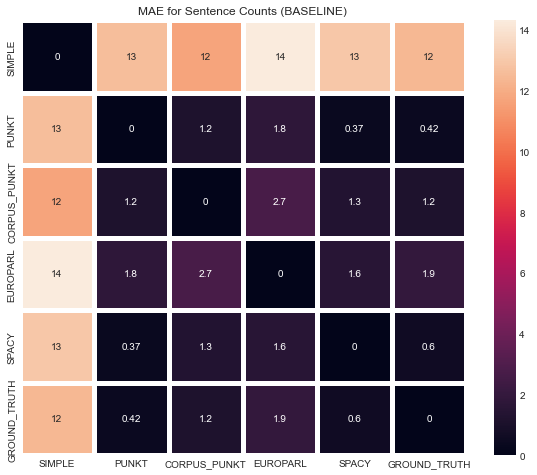

In [7]:
plot_mae([df[col] for col in df], 'BASELINE')

In [8]:
df_s = df.subtract(df.GROUND_TRUTH, axis=0).abs().divide(df.GROUND_TRUTH, axis=0).agg(['mean', 'count', 'std']).T
c_r = 1.96*df_s['std']/df_s['count']**.5
df_s['c95_hi'] = df_s['mean'] + c_r
df_s['c95_lo'] = df_s['mean'] - c_r
df_s['c95'] = c_r
df_s = df_s.T
df_s

,SIMPLE,PUNKT,CORPUS_PUNKT,EUROPARL,SPACY,GROUND_TRUTH
mean,0.874655,0.033666,0.069561,0.068400,0.038982,0.0
count,199.000000,199.000000,199.000000,199.000000,199.000000,199.0
std,0.674982,0.110852,0.153054,0.101259,0.088880,0.0
c95_hi,0.968437,0.049068,0.090826,0.082470,0.051331,0.0
c95_lo,0.780872,0.018264,0.048295,0.054331,0.026633,0.0
c95,0.093783,0.015402,0.021265,0.014069,0.012349,0.0


In [9]:
df_s = df.subtract(df.GROUND_TRUTH, axis=0).abs().agg(['mean', 'count', 'std']).T
c_r = 1.96*df_s['std']/df_s['count']**.5
df_s['c95_hi'] = df_s['mean'] + c_r
df_s['c95_lo'] = df_s['mean'] - c_r
df_s['c95'] = c_r
df_s = df_s.T
df_s

,SIMPLE,PUNKT,CORPUS_PUNKT,EUROPARL,SPACY,GROUND_TRUTH
mean,12.402010,0.422111,1.165829,1.929648,0.597990,0.0
count,199.000000,199.000000,199.000000,199.000000,199.000000,199.0
std,14.104559,0.842503,2.645300,3.588010,1.082084,0.0
c95_hi,14.361708,0.539169,1.533369,2.428169,0.748335,0.0
c95_lo,10.442313,0.305053,0.798289,1.431128,0.447644,0.0
c95,1.959698,0.117058,0.367540,0.498521,0.150345,0.0


In [10]:
tok_p = build_sentence_tokenizer(SentenceTokenizerStrategy.PUNKT, language='english')
tok_sp = build_sentence_tokenizer(SentenceTokenizerStrategy.EUROPARL, language='english')

for text in texts:
    sent_p = tok_p.tokenize_text(text)
    sent_sp = tok_sp.tokenize_text(text)
    if len(sent_p) != len(sent_sp) and len(sent_p) < 5:
        print('\n'.join(sent_p), '\n', '-'*10, '\n', '\n'.join(sent_sp))
        print('-'*60)
        print('-'*60)

Clark J. Vitulli was named senior vice president and general manager of this U.S. sales and marketing arm of Japanese auto maker Mazda Motor Corp.
In the new position he will oversee Mazda 's U.S. sales, service, parts and marketing operations.
Previously, Mr. Vitulli, 43 years old, was general marketing manager of Chrysler Corp. 's Chrysler division.
He had been a sales and marketing executive with Chrysler for 20 years. 
 ---------- 
 Clark J. Vitulli was named senior vice president and general manager of this U.S. sales and marketing arm of Japanese auto maker Mazda Motor Corp. In the new position he will oversee Mazda 's U.S. sales, service, parts and marketing operations.
Previously, Mr. Vitulli, 43 years old, was general marketing manager of Chrysler Corp. 's Chrysler division.
He had been a sales and marketing executive with Chrysler for 20 years.
------------------------------------------------------------
------------------------------------------------------------
Cooper Tire